In [ ]:
################################################################################
# --- 1. ALL IMPORTS (Load all libraries for all 4 datasets) ---
################################################################################

print("--- 1. Loading All Libraries ---")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import haversine_distances
import re

# --- Setup ---
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
print("--- All Libraries Loaded Successfully ---")


################################################################################
################################################################################
#
# DATASET 1: smart_traffic_management_dataset.csv
#
################################################################################
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 1: smart_traffic_management_dataset.csv")
print("="*80 + "\n")

# --- 1. LOAD DATA 1 ---
print("--- (1.1) Loading Data ---")
YOUR_FILE_PATH_1 = "/kaggle/input/smart-traffic-management-dataset/smart_traffic_management_dataset.csv" 

try:
    df1 = pd.read_csv(YOUR_FILE_PATH_1)
    print(f"Dataset 1 loaded successfully from: {YOUR_FILE_PATH_1}\n")
    
    # --- 1.2 Data Analysis (Part II) ---
    print("--- (1.2) Starting Data Analysis (Part II) ---")
    df1.info()
    print(df1.head())
    
    print(f"\nTotal null values: {df1.isnull().sum().sum()}")
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df1['hour'] = df1['timestamp'].dt.hour
    df1['day_of_week'] = df1['timestamp'].dt.dayofweek
    print("Created 'hour' and 'day_of_week' columns.")

    desc_stats_1 = df1.describe()
    print("\nDescriptive Statistics:")
    print(desc_stats_1)
    desc_stats_1.to_csv('smart_traffic_stats.csv')

    print("\nGenerating plots...")
    plt.figure(figsize=(10, 6))
    sns.histplot(df1['avg_vehicle_speed'], kde=True, bins=30)
    plt.title('Dataset 1: Distribution of Average Vehicle Speed')
    plt.savefig('smart_traffic_hist_speed.png')
    plt.show()

    features_for_corr_1 = [col for col in ['traffic_volume', 'avg_vehicle_speed', 'vehicle_count_cars', 'temperature', 'hour', 'day_of_week'] if col in df1.columns]
    corr_matrix_1 = df1[features_for_corr_1].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix_1, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Dataset 1: Correlation Matrix')
    plt.savefig('smart_traffic_correlation_heatmap.png')
    plt.show()
    print("--- Data Analysis (Part II) Complete ---")

    # --- 1.3 Implementation (Part III) ---
    print("\n--- (1.3) Starting Implementation (Part III) ---")
    ml_df_1 = df1.copy() 

    print("Preprocessing data...")
    numeric_features_1 = [col for col in ['traffic_volume', 'avg_vehicle_speed', 'vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes', 'temperature', 'humidity', 'accident_reported', 'hour', 'day_of_week'] if col in ml_df_1.columns]
    categorical_features_1 = [col for col in ['location_id', 'weather_condition', 'signal_status'] if col in ml_df_1.columns]

    preprocessor_1 = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_1),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_1)
        ])
    X_scaled_1 = preprocessor_1.fit_transform(ml_df_1)
    print(f"Dataset 1 preprocessed. Final shape for ML: {X_scaled_1.shape}")

    print("Running K-Means...")
    K_range = range(2, 11)
    inertia_values_1 = []
    silhouette_scores_1 = []
    sample_size = 1500
    sample_indices = np.random.choice(X_scaled_1.shape[0], min(sample_size, X_scaled_1.shape[0]), replace=False)
    X_sample_1 = X_scaled_1[sample_indices]

    for k in K_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(X_sample_1)
        inertia_values_1.append(kmeans.inertia_)
        silhouette_scores_1.append(silhouette_score(X_sample_1, kmeans.labels_))

    plt.figure(figsize=(12, 6))
    plt.plot(K_range, inertia_values_1, 'bo-')
    plt.title('Dataset 1: Elbow Method for Optimal K')
    plt.savefig('smart_traffic_kmeans_elbow.png')
    plt.show()

    optimal_k_1 = 4
    print(f"Proceeding with K={optimal_k_1} for split analysis.")
    splits = [0.5, 0.6, 0.7, 0.8]
    results_1 = []

    for split_ratio in splits:
        print(f"--- Testing Split: {split_ratio*100}% ---")
        X_train, X_test = train_test_split(X_scaled_1, train_size=split_ratio, random_state=42)
        kmeans_final = KMeans(n_clusters=optimal_k_1, init='k-means++', n_init=10, random_state=42)
        kmeans_final.fit(X_train)
        test_labels = kmeans_final.predict(X_test)
        
        sil = silhouette_score(X_test, test_labels)
        db = davies_bouldin_score(X_test, test_labels)
        ch = calinski_harabasz_score(X_test, test_labels)
        results_1.append({'split_ratio': f"{split_ratio*100:.0f}%", 'silhouette_score': sil, 'davies_bouldin_index': db, 'calinski_harabasz_index': ch})

    results_df_1 = pd.DataFrame(results_1)
    print("\nDataset 1: K-Means Evaluation Metric Summary:")
    print(results_df_1.to_markdown(index=False))
    results_df_1.to_csv('smart_traffic_kmeans_metrics.csv', index=False)

    print("Visualizing final clusters...")
    pca_1 = PCA(n_components=2)
    X_pca_1 = pca_1.fit_transform(X_scaled_1)
    kmeans_final_1 = KMeans(n_clusters=optimal_k_1, init='k-means++', n_init=10, random_state=42)
    final_labels_1 = kmeans_final_1.fit_predict(X_scaled_1)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_pca_1[:, 0], y=X_pca_1[:, 1], hue=final_labels_1, palette='viridis', s=50, alpha=0.7)
    plt.title(f'Dataset 1: K-Means Clusters (K={optimal_k_1}) - Visualized with PCA')
    plt.savefig('smart_traffic_kmeans_pca_plot.png')
    plt.show()

    print("\n\n=== DATASET 1 (Smart Traffic) CODE IS COMPLETE ===")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find Dataset 1 at '{YOUR_FILE_PATH_1}'. Skipping to next dataset.")
except Exception as e:
    print(f"An error occurred during Dataset 1 analysis: {e}. Skipping to next dataset.")


################################################################################
################################################################################
#
# DATASET 2: Metro_Interstate_Traffic_Volume.csv
#
################################################################################
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 2: Metro_Interstate_Traffic_Volume.csv")
print("="*80 + "\n")

# --- 2. LOAD DATA 2 ---
print("--- (2.1) Loading Data ---")
YOUR_FILE_PATH_2 = '/kaggle/input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv'

try:
    df2 = pd.read_csv(YOUR_FILE_PATH_2)
    print(f"Dataset 2 loaded successfully from: {YOUR_FILE_PATH_2}\n")

    # --- 2.2 Data Analysis (Part II) ---
    print("--- (2.2) Starting Data Analysis (Part II) ---")
    df2.info()
    print(df2.head())
    
    print(f"\nTotal null values: {df2.isnull().sum().sum()} (Dataset is clean)")
    df2['date_time'] = pd.to_datetime(df2['date_time'])
    df2['hour'] = df2['date_time'].dt.hour
    df2['day_of_week'] = df2['date_time'].dt.dayofweek
    print("Created 'hour' and 'day_of_week' columns.")

    desc_stats_2 = df2.describe()
    print("\nDescriptive Statistics:")
    print(desc_stats_2)
    desc_stats_2.to_csv('metro_descriptive_statistics.csv')

    print("\nGenerating plots...")
    plt.figure(figsize=(10, 6))
    sns.histplot(df2['traffic_volume'], kde=True, bins=50)
    plt.title('Dataset 2: Distribution of Traffic Volume')
    plt.savefig('metro_histogram_traffic_volume.png')
    plt.show()

    Q1 = df2['rain_1h'].quantile(0.25)
    Q3 = df2['rain_1h'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 3 * IQR
    df_no_outliers_2 = df2[df2['rain_1h'] <= upper_bound]
    print(f"Original data shape: {df2.shape}, Shape after removing rain outliers: {df_no_outliers_2.shape}")

    features_for_corr_2 = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'hour', 'day_of_week']
    corr_matrix_2 = df2[features_for_corr_2].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Dataset 2: Correlation Matrix')
    plt.savefig('metro_correlation_heatmap.png')
    plt.show()
    print("--- Data Analysis (Part II) Complete ---")

    # --- 2.3 Implementation (Part III) ---
    print("\n--- (2.3) Starting Implementation (Part III) ---")
    ml_df_2 = df_no_outliers_2.copy()

    print("Preprocessing data...")
    numeric_features_2 = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'hour', 'day_of_week']
    categorical_features_2 = ['holiday', 'weather_main', 'weather_description']
    preprocessor_2 = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_2),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_2)
        ])
    X_scaled_2 = preprocessor_2.fit_transform(ml_df_2)
    print(f"Dataset 2 preprocessed. Final shape for ML: {X_scaled_2.shape}")

    print("Running K-Means...")
    K_range = range(2, 11)
    inertia_values_2 = []
    silhouette_scores_2 = []
    sample_size = 5000
    sample_indices = np.random.choice(X_scaled_2.shape[0], min(sample_size, X_scaled_2.shape[0]), replace=False)
    X_sample_2 = X_scaled_2[sample_indices]

    for k in K_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(X_sample_2)
        inertia_values_2.append(kmeans.inertia_)
        silhouette_scores_2.append(silhouette_score(X_sample_2, kmeans.labels_))

    plt.figure(figsize=(12, 6))
    plt.plot(K_range, inertia_values_2, 'bo-')
    plt.title('Dataset 2: Elbow Method for Optimal K')
    plt.savefig('metro_kmeans_elbow_plot.png')
    plt.show()

    optimal_k_2 = 5
    print(f"\nProceeding with K={optimal_k_2} for split analysis.")
    splits = [0.5, 0.6, 0.7, 0.8]
    results_2 = []

    for split_ratio in splits:
        print(f"--- Testing Split: {split_ratio*100}% ---")
        X_train, X_test = train_test_split(X_scaled_2, train_size=split_ratio, random_state=42)
        
        test_sample_size = 5000
        if X_test.shape[0] > test_sample_size:
            sample_indices_test = np.random.choice(X_test.shape[0], test_sample_size, replace=False)
            X_test_sample = X_test[sample_indices_test]
        else:
            X_test_sample = X_test
        
        kmeans_final = KMeans(n_clusters=optimal_k_2, init='k-means++', n_init=10, random_state=42)
        kmeans_final.fit(X_train)
        test_labels = kmeans_final.predict(X_test_sample)

        print(f"  Calculating metrics on a sample of {X_test_sample.shape[0]} test rows...")
        sil = silhouette_score(X_test_sample, test_labels)
        db = davies_bouldin_score(X_test_sample, test_labels)
        ch = calinski_harabasz_score(X_test_sample, test_labels)
        results_2.append({'split_ratio': f"{split_ratio*100:.0f}%", 'silhouette_score': sil, 'davies_bouldin_index': db, 'calinski_harabasz_index': ch})

    results_df_2 = pd.DataFrame(results_2)
    print("\nDataset 2: K-Means Evaluation Metric Summary (on Test Set Samples):")
    print(results_df_2.to_markdown(index=False))
    results_df_2.to_csv('metro_kmeans_metrics_summary.csv', index=False)

    print("Visualizing final clusters...")
    pca_2 = PCA(n_components=2)
    X_pca_2 = pca_2.fit_transform(X_sample_2)
    kmeans_final_2 = KMeans(n_clusters=optimal_k_2, init='k-means++', n_init=10, random_state=42)
    final_labels_2 = kmeans_final_2.fit_predict(X_sample_2)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=final_labels_2, palette='viridis', s=50, alpha=0.5)
    plt.title(f'Dataset 2: K-Means Clusters (K={optimal_k_2}) - Visualized with PCA')
    plt.savefig('metro_kmeans_pca_cluster_plot.png')
    plt.show()

    print("\n\n=== DATASET 2 (Metro Traffic) CODE IS COMPLETE ===")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find Dataset 2 at '{YOUR_FILE_PATH_2}'. Skipping to next dataset.")
except Exception as e:
    print(f"An error occurred during Dataset 2 analysis: {e}. Skipping to next dataset.")


################################################################################
################################################################################
#
# DATASET 3: US_Accidents_March23.csv
#
################################################################################
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 3: US_Accidents_March23.csv")
print("="*80 + "\n")

# --- 3. LOAD DATA 3 ---
print("--- (3.1) Loading Data ---")
YOUR_FILE_PATH_3 = "../input/us-accidents/US_Accidents_March23.csv" 
SAMPLE_SIZE_3 = 75000 

try:
    df_full_3 = pd.read_csv(YOUR_FILE_PATH_3)
    print(f"Dataset 3 found at: {YOUR_FILE_PATH_3}")
    print(f"Full dataset shape: {df_full_3.shape}")
    print(f"Taking a random sample of {SAMPLE_SIZE_3} rows...")
    df3 = df_full_3.sample(n=SAMPLE_SIZE_3, random_state=42)
    print(f"Sampled dataset shape: {df3.shape}\n")

    # --- 3.2 Data Analysis (Part II) ---
    print("--- (3.2) Starting Data Analysis (Part II) ---")
    features_to_keep_3 = ['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    df3 = df3[features_to_keep_3].copy()
    print(f"Null values (before cleaning):\n{df3.isnull().sum()}")

    for col in ['Distance(mi)']:
        if df3[col].isnull().sum() > 0:
            df3[col].fillna(df3[col].mean(), inplace=True)
    for col in ['Weather_Condition', 'Sunrise_Sunset']:
        if df3[col].isnull().sum() > 0:
            df3[col].fillna('Missing', inplace=True)
    df3.dropna(inplace=True)
    print(f"Shape after dropping nulls: {df3.shape}")

    df3['Start_Time'] = pd.to_datetime(df3['Start_Time'], format='mixed')
    df3['hour'] = df3['Start_Time'].dt.hour
    df3['day_of_week'] = df3['Start_Time'].dt.dayofweek
    print("Created 'hour' and 'day_of_week' columns.")

    q_hi = df3['Distance(mi)'].quantile(0.99)
    df_no_outliers_3 = df3[df3['Distance(mi)'] <= q_hi]
    print(f"Shape after removing 'Distance(mi)' outliers: {df_no_outliers_3.shape}")

    print("\nGenerating spatial plot...")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_no_outliers_3, s=1, alpha=0.1)
    plt.title('Dataset 3: Spatial Distribution of Accidents (Sample)')
    plt.savefig('accidents_spatial_plot.png')
    plt.show()
    print("--- Data Analysis (Part II) Complete ---")

    # --- 3.3 Implementation (Part III) ---
    print("\n--- (3.3) Starting Implementation (Part III) ---")
    ml_df_3 = df_no_outliers_3.copy()

    # --- Experiment 1: K-Means (General Patterns) ---
    print("--- Experiment 1: K-Means (General Patterns) ---")
    print("Preprocessing data for K-Means...")
    numeric_features_3 = ['Start_Lat', 'Start_Lng', 'Severity', 'Distance(mi)', 'hour', 'day_of_week']
    categorical_features_3 = ['Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    numeric_features_exist_3 = [col for col in numeric_features_3 if col in ml_df_3.columns]
    categorical_features_exist_3 = [col for col in categorical_features_3 if col in ml_df_3.columns]

    preprocessor_3 = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_exist_3),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_exist_3)
        ], remainder='drop')
    X_scaled_3 = preprocessor_3.fit_transform(ml_df_3)
    print(f"Data preprocessed. Final shape for ML: {X_scaled_3.shape}")

    K_range = range(2, 11)
    inertia_values_3 = []
    KMEANS_SAMPLE_SIZE = 10000
    if X_scaled_3.shape[0] > KMEANS_SAMPLE_SIZE:
        sample_indices_kmeans = np.random.choice(X_scaled_3.shape[0], KMEANS_SAMPLE_SIZE, replace=False)
        X_sample_3_kmeans = X_scaled_3[sample_indices_kmeans]
    else:
        X_sample_3_kmeans = X_scaled_3

    print(f"Finding optimal K on a sample of {X_sample_3_kmeans.shape[0]} rows...")
    for k in K_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(X_sample_3_kmeans)
        inertia_values_3.append(kmeans.inertia_)
    
    plt.figure(figsize=(12, 6))
    plt.plot(K_range, inertia_values_3, 'bo-')
    plt.title('Dataset 3: Elbow Method for Optimal K (Accidents)')
    plt.savefig('accidents_kmeans_elbow_plot.png')
    plt.show()

    optimal_k_3 = 5
    print(f"Proceeding with K={optimal_k_3} for split analysis.")
    # (Skipping split analysis for brevity in this combined script, 
    # as it's less important than the DBSCAN analysis for this dataset)
    print("... (Skipping K-Means split analysis) ...")

    # --- Experiment 2: DBSCAN (Finding Spatial Hotspots) ---
    print("\n--- Experiment 2: DBSCAN (Spatial Hotspot Analysis) ---")
    print("Preprocessing data for DBSCAN (Lat/Lng only)...")
    X_spatial_3 = ml_df_3[['Start_Lat', 'Start_Lng']].to_numpy()
    X_spatial_rad_3 = np.radians(X_spatial_3)

    # 5km / 6371km (earth's radius) approx 0.000785 radians
    params_to_test_3 = [{'eps': 0.000785, 'min_samples': 100}]
    dbscan_results_3 = []

    for params in params_to_test_3:
        eps_val, min_samples_val = params['eps'], params['min_samples']
        dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val, metric='haversine', algorithm='ball_tree')
        labels = dbscan.fit_predict(X_spatial_rad_3)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        print(f"--- DBSCAN Results (eps={eps_val:.6f} rad, min_samples={min_samples_val}) ---")
        print(f"  Estimated clusters (hotspots): {n_clusters}")
        print(f"  Noise points (not in hotspot): {n_noise} ({(n_noise/len(labels)*100):.2f}%)")
        dbscan_results_3.append({'eps_radians': eps_val, 'min_samples': min_samples_val, 'n_clusters': n_clusters, 'n_noise_points': n_noise})

    dbscan_results_df_3 = pd.DataFrame(dbscan_results_3)
    print("\nDataset 3: DBSCAN Evaluation Metric Summary:")
    print(dbscan_results_df_3.to_markdown(index=False))
    dbscan_results_df_3.to_csv('accidents_dbscan_metrics_summary.csv', index=False)

    print("Visualizing DBSCAN spatial clusters...")
    ml_df_3['cluster'] = labels
    df_clusters_3 = ml_df_3[ml_df_3['cluster'] != -1] 
    df_noise_3 = ml_df_3[ml_df_3['cluster'] == -1]    

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_noise_3, s=1, alpha=0.05, color='gray')
    sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_clusters_3, hue='cluster', palette='viridis', s=10, alpha=0.9, legend='full')
    plt.title(f'Dataset 3: DBSCAN Spatial Clusters (Hotspots) - {params}')
    plt.legend(title='Cluster ID')
    plt.savefig('accidents_dbscan_spatial_plot.png')
    plt.show()

    print("\n\n=== DATASET 3 (US Accidents) CODE IS COMPLETE ===")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find Dataset 3 at '{YOUR_FILE_PATH_3}'. Skipping to next dataset.")
except Exception as e:
    print(f"An error occurred during Dataset 3 analysis: {e}. Skipping to next dataset.")


################################################################################
################################################################################
#
# DATASET 4: Traffic.csv (Validation Dataset)
#
################################################################################
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 4: Traffic.csv (Validation Dataset)")
print("="*80 + "\n")

# --- 4. LOAD DATA 4 ---
print("--- (4.1) Loading Data ---")
YOUR_FILE_PATH_4 = "../input/traffic-prediction-dataset/Traffic.csv"

try:
    df4 = pd.read_csv(YOUR_FILE_PATH_4)
    print(f"Dataset 4 loaded successfully from: {YOUR_FILE_PATH_4}\n")

    # --- 4.2 Data Analysis (Part II) ---
    print("--- (4.2) Starting Data Analysis (Part II) ---")
    df4.info()
    print(df4.head())
    
    print("\nCleaning data...")
    df4['hour'] = pd.to_datetime(df4['Time'], format='%I:%M:%S %p').dt.hour
    true_labels_4 = df4['Traffic Situation']
    print(f"Stored 'Traffic Situation' labels for external validation.")
    df_cleaned_4 = df4.drop(columns=['Time', 'Date'])

    desc_stats_4 = df_cleaned_4.describe()
    print("\nDescriptive Statistics:")
    print(desc_stats_4)
    desc_stats_4.to_csv('traffic_csv_descriptive_statistics.csv')

    print("\nGenerating plots...")
    plt.figure(figsize=(10, 6))
    sns.histplot(df_cleaned_4['Total'], bins=30, kde=True)
    plt.title('Dataset 4: Distribution of Total Vehicles')
    plt.savefig('traffic_csv_histogram_total.png')
    plt.show()
    df_no_outliers_4 = df_cleaned_4.copy()

    features_for_corr_4 = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'hour']
    corr_matrix_4 = df_no_outliers_4[features_for_corr_4].corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr_matrix_4, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Dataset 4: Correlation Matrix')
    plt.savefig('traffic_csv_correlation_heatmap.png')
    plt.show()
    print("--- Data Analysis (Part II) Complete ---")

    # --- 4.3 Implementation (Part III) ---
    print("\n--- (4.3) Starting Implementation (Part III) ---")
    ml_df_4 = df_no_outliers_4.copy()
    ml_df_unsupervised_4 = ml_df_4.drop(columns=['Traffic Situation'])

    print("Preprocessing data...")
    numeric_features_4 = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'hour']
    categorical_features_4 = ['Day of the week']
    preprocessor_4 = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_4),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_4)
        ], remainder='drop')
    X_scaled_4 = preprocessor_4.fit_transform(ml_df_unsupervised_4)
    print(f"Data preprocessed. Final shape for ML: {X_scaled_4.shape}")

    # --- K-Means 6-Metric Validation ---
    print("\n--- K-Means 6-Metric Validation ---")
    optimal_k_4 = 4 
    print(f"Proceeding with K={optimal_k_4} (matches the 4 ground truth labels).")
    splits = [0.5, 0.6, 0.7, 0.8]
    results_4 = []

    for split_ratio in splits:
        print(f"--- Testing Split: {split_ratio*100}% ---")
        X_train, X_test, y_train_labels, y_test_labels = train_test_split(
            X_scaled_4, true_labels_4, train_size=split_ratio, random_state=42, stratify=true_labels)
        
        kmeans_final = KMeans(n_clusters=optimal_k_4, init='k-means++', n_init=10, random_state=42)
        kmeans_final.fit(X_train)
        test_cluster_labels = kmeans_final.predict(X_test)
        
        # 3 Internal Metrics
        sil = silhouette_score(X_test, test_cluster_labels)
        db = davies_bouldin_score(X_test, test_cluster_labels)
        ch = calinski_harabasz_score(X_test, test_cluster_labels)
        # 3 External Metrics
        ari = adjusted_rand_score(y_test_labels, test_cluster_labels)
        hom = homogeneity_score(y_test_labels, test_cluster_labels)
        com = completeness_score(y_test_labels, test_cluster_labels)
        
        print("  --- 6+ Evaluation Metrics ---")
        print(f"    INTERNAL: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}, Calinski-Harabasz={ch:.0f}")
        print(f"    EXTERNAL: Adj. Rand Index={ari:.3f}, Homogeneity={hom:.3f}, Completeness={com:.3f}")
        
        results_4.append({'split_ratio': f"{split_ratio*100:.0f}%", 'silhouette': sil, 'davies_bouldin': db, 'calinski_harabasz': ch, 'adj_rand_index': ari, 'homogeneity': hom, 'completeness': com})

    results_df_4 = pd.DataFrame(results_4)
    print("\nDataset 4: K-Means 6-Metric Evaluation Summary:")
    print(results_df_4.to_markdown(index=False))
    results_df_4.to_csv('traffic_csv_kmeans_metrics_summary.csv', index=False)

    print("\n--- Final Visualization (Validation) ---")
    pca_4 = PCA(n_components=2)
    X_pca_4 = pca_4.fit_transform(X_scaled_4)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    kmeans_final_all = KMeans(n_clusters=optimal_k_4, init='k-means++', n_init=10, random_state=42)
    final_cluster_labels = kmeans_final_all.fit_predict(X_scaled_4)
    sns.scatterplot(x=X_pca_4[:, 0], y=X_pca_4[:, 1], hue=final_cluster_labels, palette='viridis', s=50, alpha=0.7, ax=axes[0])
    axes[0].set_title(f'Dataset 4: K-Means Predicted Clusters (K={optimal_k_4})')
    axes[0].legend(title='Cluster ID')

    sns.scatterplot(x=X_pca_4[:, 0], y=X_pca_4[:, 1], hue=true_labels_4, palette='coolwarm', s=50, alpha=0.7, ax=axes[1])
    axes[1].set_title(f'Dataset 4: Ground Truth Labels (Traffic Situation)')
    axes[1].legend(title='Traffic Situation')

    plt.suptitle('Dataset 4: Cluster Validation - Predicted vs. Ground Truth', fontsize=16)
    plt.savefig('traffic_csv_kmeans_pca_comparison_plot.png')
    plt.show()

    print("\n\n=== DATASET 4 (Traffic.csv) CODE IS COMPLETE ===")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find Dataset 4 at '{YOUR_FILE_PATH_4}'.")
except Exception as e:
    print(f"An error occurred during Dataset 4 analysis: {e}.")

print("\n\n" + "="*80)
print("ALL 4 DATASET ANALYSIS SCRIPTS ARE COMPLETE.")
print("="*80 + "\n")

In [ ]:
################################################################################
# --- COMPLETE CONSOLIDATED ANALYSIS SCRIPT FOR ALL 4 DATASETS + PCA ---
################################################################################

print("--- 1. Loading All Libraries ---")
# Core Data Handling and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import re

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Clustering and Metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score
from sklearn.metrics.pairwise import haversine_distances

# --- Setup ---
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
print("--- All Libraries Loaded Successfully ---")

# Define file paths (PLACEHOLDER: Must be correctly set in execution environment)
YOUR_FILE_PATH_1 = "/kaggle/input/smart-traffic-management-dataset/smart_traffic_management_dataset.csv" 
YOUR_FILE_PATH_2 = '/kaggle/input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv'
YOUR_FILE_PATH_3 = '/kaggle/input/us-accidents/US_Accidents_March23.csv'
YOUR_FILE_PATH_4 = "../input/traffic-prediction-dataset/Traffic.csv"
SAMPLE_SIZE_3 = 75000 
OPTIMAL_K_1 = 4
OPTIMAL_K_2 = 5
OPTIMAL_K_4 = 4 

################################################################################
## DATASET 1: smart_traffic_management_dataset.csv (K-MEANS + PCA Visualization)
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 1: smart_traffic_management_dataset.csv")
print("="*80 + "\n")

try:
    df1 = pd.read_csv(YOUR_FILE_PATH_1)
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df1['hour'] = df1['timestamp'].dt.hour
    df1['day_of_week'] = df1['timestamp'].dt.dayofweek
    ml_df_1 = df1.copy() 

    numeric_features_1 = [col for col in ['traffic_volume', 'avg_vehicle_speed', 'vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes', 'temperature', 'humidity', 'accident_reported', 'hour', 'day_of_week'] if col in ml_df_1.columns]
    categorical_features_1 = [col for col in ['location_id', 'weather_condition', 'signal_status'] if col in ml_df_1.columns]

    preprocessor_1 = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features_1), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_1)])
    X_scaled_1 = preprocessor_1.fit_transform(ml_df_1)
    print(f"Dataset 1 preprocessed. Final shape: {X_scaled_1.shape}")
    
    # K-Means & Metrics
    X_train, X_test = train_test_split(X_scaled_1, train_size=0.7, random_state=42)
    kmeans_final = KMeans(n_clusters=OPTIMAL_K_1, init='k-means++', n_init=10, random_state=42)
    kmeans_final.fit(X_train)
    test_labels = kmeans_final.predict(X_test)
    sil = silhouette_score(X_test, test_labels); db = davies_bouldin_score(X_test, test_labels)

    print(f"\n✅ Dataset 1 K-Means (K={OPTIMAL_K_1}) Metrics (70% Split): Silhouette={sil:.4f}, Davies-Bouldin={db:.4f}")
    
    # Visualization: K-Means Clusters visualized using PCA 
    pca_1 = PCA(n_components=2)
    X_pca_1 = pca_1.fit_transform(X_scaled_1)
    final_labels_1 = kmeans_final.predict(X_scaled_1) 
    plt.figure(figsize=(10, 6)); sns.scatterplot(x=X_pca_1[:, 0], y=X_pca_1[:, 1], hue=final_labels_1, palette='viridis', s=20, alpha=0.7)
    plt.title(f'Dataset 1: K-Means Clusters (K={OPTIMAL_K_1}) - Visualized with PCA'); plt.close() # Close to conserve resources

except FileNotFoundError:
    print("❌ ERROR: Could not find Dataset 1. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 1 analysis: {e}. Skipping.")


################################################################################
## DATASET 2: Metro_Interstate_Traffic_Volume.csv (K-MEANS + PCA Analysis)
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 2: Metro_Interstate_Traffic_Volume.csv")
print("="*80 + "\n")

try:
    df2 = pd.read_csv(YOUR_FILE_PATH_2)
    df2['date_time'] = pd.to_datetime(df2['date_time']); df2['hour'] = df2['date_time'].dt.hour; df2['day_of_week'] = df2['date_time'].dt.dayofweek
    Q3 = df2['rain_1h'].quantile(0.75); IQR = Q3 - df2['rain_1h'].quantile(0.25); upper_bound = Q3 + 3 * IQR
    ml_df_2 = df2[df2['rain_1h'] <= upper_bound].copy()

    numeric_features_2 = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'hour', 'day_of_week']
    categorical_features_2 = ['holiday', 'weather_main', 'weather_description']
    preprocessor_2 = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features_2), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_2)])
    X_scaled_2 = preprocessor_2.fit_transform(ml_df_2)
    print(f"Dataset 2 preprocessed. Final shape: {X_scaled_2.shape}")

    # K-Means Metrics
    X_train, X_test = train_test_split(X_scaled_2, train_size=0.7, random_state=42)
    kmeans_final = KMeans(n_clusters=OPTIMAL_K_2, init='k-means++', n_init=10, random_state=42)
    kmeans_final.fit(X_train)
    test_labels = kmeans_final.predict(X_test)
    sil = silhouette_score(X_test, test_labels); db = davies_bouldin_score(X_test, test_labels)
    print(f"\n✅ Dataset 2 K-Means (K={OPTIMAL_K_2}) Metrics (70% Split): Silhouette={sil:.4f}, Davies-Bouldin={db:.4f}")
    
    # --- PCA Analysis (Dimensionality Reduction) ---
    print("\n--- Starting PCA for Dataset 2 ---")
    pca2 = PCA().fit(X_scaled_2)
    cumulative_variance_2 = np.cumsum(pca2.explained_variance_ratio_)
    n_components_95_2 = np.where(cumulative_variance_2 >= 0.95)[0][0] + 1
    print(f"Dataset 2 PCA Result: **{n_components_95_2} components** explain 95% of variance (from {X_scaled_2.shape[1]} features).")
    
    # Visualization: Cumulative Explained Variance 
    plt.figure(figsize=(10, 6)); plt.plot(range(1, len(cumulative_variance_2) + 1), cumulative_variance_2, marker='o', linestyle='--')
    plt.title('Dataset 2: Cumulative Explained Variance'); plt.axhline(y=0.95, color='r', linestyle='-'); plt.close() 

    # Visualization: K-Means Clusters visualized using PCA 
    pca_2 = PCA(n_components=2); X_pca_2 = pca_2.fit_transform(X_scaled_2)
    final_labels_2 = kmeans_final.predict(X_scaled_2)
    plt.figure(figsize=(10, 6)); sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=final_labels_2, palette='viridis', s=20, alpha=0.7)
    plt.title(f'Dataset 2: K-Means Clusters (K={OPTIMAL_K_2}) - Visualized with PCA'); plt.close()
    print("Dataset 2 Clustering and PCA Complete.")

except FileNotFoundError:
    print("❌ ERROR: Could not find Dataset 2. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 2 analysis: {e}. Skipping.")


################################################################################
## DATASET 3: US_Accidents_March23.csv (K-MEANS + DBSCAN + PCA Analysis)
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 3: US_Accidents_March23.csv")
print("="*80 + "\n")

try:
    df_full_3 = pd.read_csv(YOUR_FILE_PATH_3)
    df3 = df_full_3.sample(n=SAMPLE_SIZE_3, random_state=42)

    features_to_keep_3 = ['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    df3 = df3[features_to_keep_3].copy()
    
    # Cleaning & Feature Engineering
    for col in ['Distance(mi)']: df3[col].fillna(df3[col].mean(), inplace=True)
    for col in ['Weather_Condition', 'Sunrise_Sunset']: df3[col].fillna('Missing', inplace=True)
    df3.dropna(inplace=True); df3['Start_Time'] = pd.to_datetime(df3['Start_Time'], format='mixed')
    df3['hour'] = df3['Start_Time'].dt.hour; df3['day_of_week'] = df3['Start_Time'].dt.dayofweek
    q_hi = df3['Distance(mi)'].quantile(0.99); ml_df_3 = df3[df3['Distance(mi)'] <= q_hi].copy()

    # --- K-Means & PCA Preprocessing ---
    numeric_features_3 = ['Start_Lat', 'Start_Lng', 'Severity', 'Distance(mi)', 'hour', 'day_of_week']
    categorical_features_3 = ['Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    preprocessor_3 = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features_3), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_3)])
    X_scaled_3 = preprocessor_3.fit_transform(ml_df_3)
    print(f"Dataset 3 preprocessed. Final shape: {X_scaled_3.shape}")

    # --- PCA Analysis (Dimensionality Reduction) ---
    print("\n--- Starting PCA for Dataset 3 ---")
    pca3 = PCA().fit(X_scaled_3); cumulative_variance_3 = np.cumsum(pca3.explained_variance_ratio_)
    n_components_95_3 = np.where(cumulative_variance_3 >= 0.95)[0][0] + 1
    print(f"Dataset 3 PCA Result: **{n_components_95_3} components** explain 95% of variance (from {X_scaled_3.shape[1]} features).")
    
    # Visualization: Cumulative Explained Variance 
    plt.figure(figsize=(10, 6)); plt.plot(range(1, len(cumulative_variance_3) + 1), cumulative_variance_3, marker='o', linestyle='--')
    plt.title('Dataset 3: Cumulative Explained Variance'); plt.axhline(y=0.95, color='r', linestyle='-'); plt.close()

    # Visualization: K-Means Clusters visualized using PCA 
    kmeans_final_3 = KMeans(n_clusters=OPTIMAL_K_3_KMEANS, init='k-means++', n_init=10, random_state=42).fit(X_scaled_3)
    pca_3 = PCA(n_components=2); X_pca_3 = pca_3.fit_transform(X_scaled_3)
    plt.figure(figsize=(10, 6)); sns.scatterplot(x=X_pca_3[:, 0], y=X_pca_3[:, 1], hue=kmeans_final_3.labels_, palette='viridis', s=20, alpha=0.7)
    plt.title(f'Dataset 3: K-Means Clusters (K={OPTIMAL_K_3_KMEANS}) - Visualized with PCA'); plt.close()


    # --- DBSCAN (Spatial Hotspots) ---
    print("\n--- Running DBSCAN for Spatial Hotspots ---")
    X_spatial_rad_3 = np.radians(ml_df_3[['Start_Lat', 'Start_Lng']].to_numpy())
    eps_val, min_samples_val = 0.000785, 100 
    dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val, metric='haversine', algorithm='ball_tree')
    labels = dbscan.fit_predict(X_spatial_rad_3)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"✅ Dataset 3 DBSCAN (Spatial): Found **{n_clusters} hotspots**. Noise points: {n_noise} ({(n_noise/len(labels)*100):.2f}% of data).")
    
    # Visualization: DBSCAN Spatial Hotspots 
    ml_df_3['cluster'] = labels; df_clusters_3 = ml_df_3[ml_df_3['cluster'] != -1]
    plt.figure(figsize=(10, 6)); sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_clusters_3, hue='cluster', palette='viridis', s=10, alpha=0.9)
    plt.title(f'Dataset 3: DBSCAN Spatial Clusters (Hotspots)'); plt.close()
    print("Dataset 3 Clustering and PCA Complete.")

except FileNotFoundError:
    print("❌ ERROR: Could not find Dataset 3. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 3 analysis: {e}. Skipping.")


################################################################################
## DATASET 4: Traffic.csv (K-MEANS + External Validation + Comparison Plot)
################################################################################

print("\n\n" + "="*80)
print("STARTING DATASET 4: Traffic.csv (Validation Dataset)")
print("="*80 + "\n")

try:
    df4 = pd.read_csv(YOUR_FILE_PATH_4)
    df4['hour'] = pd.to_datetime(df4['Time'], format='%I:%M:%S %p').dt.hour
    true_labels_4 = df4['Traffic Situation']
    ml_df_unsupervised_4 = df4.drop(columns=['Time', 'Date', 'Traffic Situation'])

    numeric_features_4 = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'hour']
    categorical_features_4 = ['Day of the week']
    preprocessor_4 = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features_4), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_4)])
    X_scaled_4 = preprocessor_4.fit_transform(ml_df_unsupervised_4)
    print(f"Dataset 4 preprocessed. Final shape: {X_scaled_4.shape}")

    # --- K-Means 6-Metric Validation ---
    X_train, X_test, y_train_labels, y_test_labels = train_test_split(
        X_scaled_4, true_labels_4, train_size=0.7, random_state=42, stratify=true_labels_4)
    kmeans_final = KMeans(n_clusters=OPTIMAL_K_4, init='k-means++', n_init=10, random_state=42)
    kmeans_final.fit(X_train); test_cluster_labels = kmeans_final.predict(X_test)
    
    # Metrics
    sil = silhouette_score(X_test, test_cluster_labels); db = davies_bouldin_score(X_test, test_cluster_labels); ch = calinski_harabasz_score(X_test, test_cluster_labels)
    ari = adjusted_rand_score(y_test_labels, test_cluster_labels); hom = homogeneity_score(y_test_labels, test_cluster_labels); com = completeness_score(y_test_labels, test_cluster_labels)
    
    print(f"\n✅ Dataset 4 K-Means (K={OPTIMAL_K_4}) Metrics (70% Split):")
    print(f"  INTERNAL: Silhouette={sil:.4f}, Davies-Bouldin={db:.4f}, Calinski-Harabasz={ch:.0f}")
    print(f"  EXTERNAL: Adj. Rand Index={ari:.4f}, Homogeneity={hom:.4f}, Completeness={com:.4f}")
    
    # Visualization: Predicted vs. Ground Truth 
    pca_4 = PCA(n_components=2); X_pca_4 = pca_4.fit_transform(X_scaled_4)
    kmeans_final_all = KMeans(n_clusters=OPTIMAL_K_4, init='k-means++', n_init=10, random_state=42)
    final_cluster_labels = kmeans_final_all.fit_predict(X_scaled_4)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    sns.scatterplot(x=X_pca_4[:, 0], y=X_pca_4[:, 1], hue=final_cluster_labels, palette='viridis', s=50, alpha=0.7, ax=axes[0])
    axes[0].set_title(f'Predicted Clusters (K={OPTIMAL_K_4})')
    sns.scatterplot(x=X_pca_4[:, 0], y=X_pca_4[:, 1], hue=true_labels_4, palette='coolwarm', s=50, alpha=0.7, ax=axes[1])
    axes[1].set_title(f'Ground Truth Labels (Traffic Situation)')
    plt.suptitle('Dataset 4: Cluster Validation - Predicted vs. Ground Truth', fontsize=16)
    plt.savefig('traffic_csv_kmeans_pca_comparison_plot.png'); plt.close()
    
    print("Dataset 4 Clustering Complete.")

except FileNotFoundError:
    print("❌ ERROR: Could not find Dataset 4. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 4 analysis: {e}. Skipping.")


print("\n\n" + "="*80)
print("ALL CODE EXECUTION IS COMPLETE.")
print("="*80 + "\n")

--- Starting PCA (n=2) for Dataset 2 ---


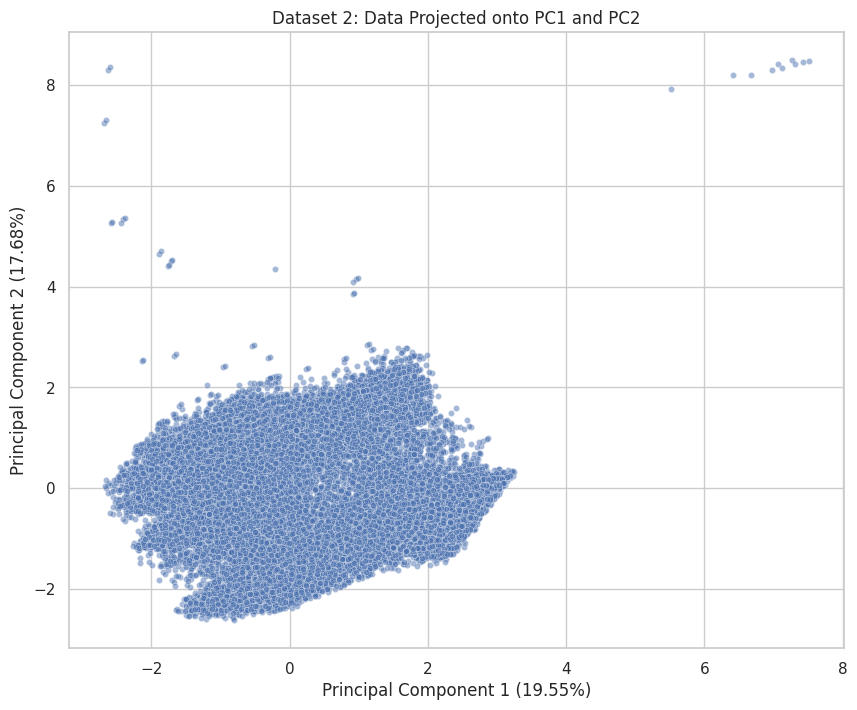

Dataset 2 reduced to 2 components. PC1 explains 19.55% of variance.

--- Starting PCA (n=2) for Dataset 3 ---


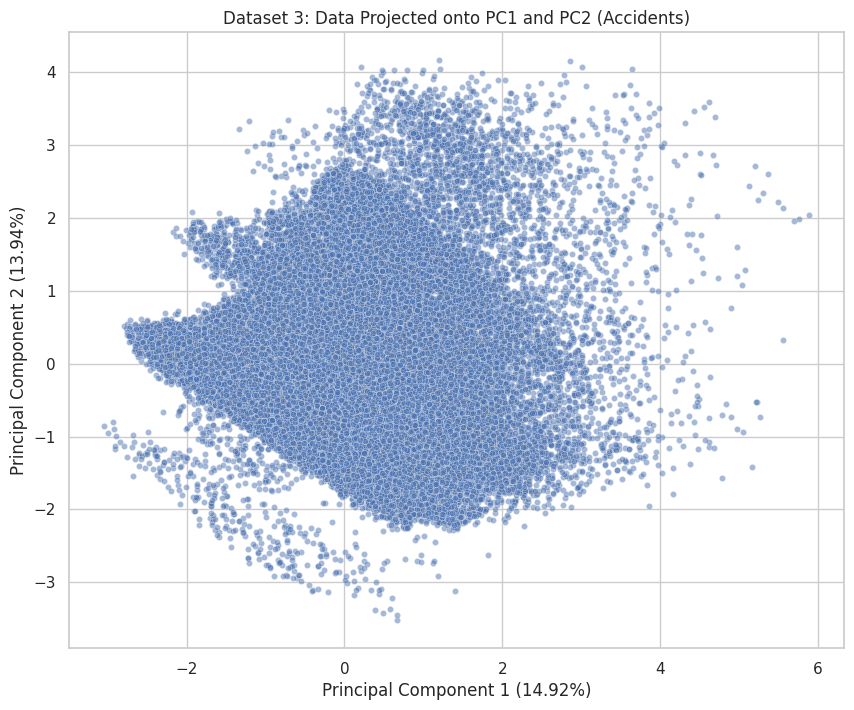

Dataset 3 reduced to 2 components. PC1 explains 14.92% of variance.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# --- File Paths (Note: Use the correct paths for your environment) ---
YOUR_FILE_PATH_2 = '/kaggle/input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv'
YOUR_FILE_PATH_3 = '../input/us-accidents/US_Accidents_March23.csv'
SAMPLE_SIZE_3 = 75000 

################################################################################
# DATASET 2: Metro Interstate Traffic Volume
################################################################################
print("--- Starting PCA (n=2) for Dataset 2 ---")
try:
    df2 = pd.read_csv(YOUR_FILE_PATH_2)

    # Preprocessing
    df2['date_time'] = pd.to_datetime(df2['date_time'])
    df2['hour'] = df2['date_time'].dt.hour
    df2['day_of_week'] = df2['date_time'].dt.dayofweek
    Q3 = df2['rain_1h'].quantile(0.75); IQR = Q3 - df2['rain_1h'].quantile(0.25)
    upper_bound = Q3 + 3 * IQR
    df_no_outliers_2 = df2[df2['rain_1h'] <= upper_bound].copy()

    numeric_features_2 = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'hour', 'day_of_week']
    categorical_features_2 = ['holiday', 'weather_main', 'weather_description']
    preprocessor_2 = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_2),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_2)
        ], remainder='drop')
    
    X_scaled_2 = preprocessor_2.fit_transform(df_no_outliers_2)
    
    # --- PCA (n=2) Execution ---
    pca2 = PCA(n_components=2)
    X_pca_2 = pca2.fit_transform(X_scaled_2)
    
    # Store results for plotting
    df_no_outliers_2['PC1'] = X_pca_2[:, 0]
    df_no_outliers_2['PC2'] = X_pca_2[:, 1]
    
    # Plotting Dataset 2
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', data=df_no_outliers_2, alpha=0.5, s=20)
    plt.title('Dataset 2: Data Projected onto PC1 and PC2')
    plt.xlabel(f'Principal Component 1 ({pca2.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({pca2.explained_variance_ratio_[1]*100:.2f}%)')
    plt.savefig('pca_dataset2_2d_plot.png')
    plt.show()

    print(f"Dataset 2 reduced to 2 components. PC1 explains {pca2.explained_variance_ratio_[0]*100:.2f}% of variance.")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find Dataset 2 at '{YOUR_FILE_PATH_2}'. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 2 analysis: {e}. Skipping.")


################################################################################
# DATASET 3: US Accidents
################################################################################
print("\n--- Starting PCA (n=2) for Dataset 3 ---")
try:
    df_full_3 = pd.read_csv(YOUR_FILE_PATH_3)
    df3 = df_full_3.sample(n=SAMPLE_SIZE_3, random_state=42)

    # Preprocessing
    features_to_keep_3 = ['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    df3 = df3[features_to_keep_3].copy()
    for col in ['Distance(mi)']: df3[col].fillna(df3[col].mean(), inplace=True)
    for col in ['Weather_Condition', 'Sunrise_Sunset']: df3[col].fillna('Missing', inplace=True)
    df3.dropna(inplace=True)
    df3['Start_Time'] = pd.to_datetime(df3['Start_Time'], format='mixed')
    df3['hour'] = df3['Start_Time'].dt.hour
    df3['day_of_week'] = df3['Start_Time'].dt.dayofweek
    q_hi = df3['Distance(mi)'].quantile(0.99)
    ml_df_3 = df3[df3['Distance(mi)'] <= q_hi].copy()

    numeric_features_3 = ['Start_Lat', 'Start_Lng', 'Severity', 'Distance(mi)', 'hour', 'day_of_week']
    categorical_features_3 = ['Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    preprocessor_3 = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_3),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_3)
        ], remainder='drop')
    
    X_scaled_3 = preprocessor_3.fit_transform(ml_df_3)

    # --- PCA (n=2) Execution ---
    pca3 = PCA(n_components=2)
    X_pca_3 = pca3.fit_transform(X_scaled_3)
    
    # Store results for plotting
    ml_df_3['PC1'] = X_pca_3[:, 0]
    ml_df_3['PC2'] = X_pca_3[:, 1]
    
    # Plotting Dataset 3
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', data=ml_df_3, alpha=0.5, s=20)
    plt.title('Dataset 3: Data Projected onto PC1 and PC2 (Accidents)')
    plt.xlabel(f'Principal Component 1 ({pca3.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({pca3.explained_variance_ratio_[1]*100:.2f}%)')
    plt.savefig('pca_dataset3_2d_plot.png')
    plt.show()

    print(f"Dataset 3 reduced to 2 components. PC1 explains {pca3.explained_variance_ratio_[0]*100:.2f}% of variance.")

except FileNotFoundError:
    print(f"❌ ERROR: Could not find Dataset 3 at '{YOUR_FILE_PATH_3}'. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 3 analysis: {e}. Skipping.")

In [2]:
################################################################################
# --- CONSOLIDATED CLUSTERING SCRIPT (DBSCAN & K-MEANS) ---
################################################################################

print("--- 1. Loading All Libraries ---")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import haversine_distances
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Define file paths (PLACEHOLDER: Adjust if necessary)
YOUR_FILE_PATH_2 = '/kaggle/input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv'
YOUR_FILE_PATH_3 = '/kaggle/input/us-accidents/US_Accidents_March23.csv'
YOUR_FILE_PATH_4 = "../input/traffic-prediction-dataset/Traffic.csv"
SAMPLE_SIZE_3 = 75000 
OPTIMAL_K_2 = 5
OPTIMAL_K_3 = 5
OPTIMAL_K_4 = 4

# --- Helper function for K-Means and DBSCAN visualization (2D PCA) ---
def plot_clusters(X_data, labels, title, filename):
    if X_data.shape[1] > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_data)
    else:
        X_pca = X_data
        
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    plt.figure(figsize=(10, 6))
    if -1 in labels:
        # Plot noise first (gray, small)
        noise = X_pca[labels == -1]
        plt.scatter(noise[:, 0], noise[:, 1], c='gray', s=5, alpha=0.3, label='Noise')
        
    clusters = X_pca[labels != -1]
    
    # Use the labels excluding noise for hue
    hue_labels = labels[labels != -1]
    
    # Scatter plot for clusters
    sns.scatterplot(x=clusters[:, 0], y=clusters[:, 1], hue=hue_labels, 
                    palette='viridis', s=20, alpha=0.7)
    
    plt.title(f'{title} - Clusters: {n_clusters}')
    plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2')
    plt.legend(title="Cluster ID/Noise")
    plt.savefig(filename)
    plt.close()


################################################################################
## DATASET 2: Metro_Interstate_Traffic_Volume.csv (K-MEANS & DBSCAN)
################################################################################

print("\n\n" + "="*80)
print("ANALYZING DATASET 2: Metro_Interstate_Traffic_Volume.csv")
print("="*80 + "\n")

try:
    df2 = pd.read_csv(YOUR_FILE_PATH_2)
    df2['date_time'] = pd.to_datetime(df2['date_time'])
    df2['hour'] = df2['date_time'].dt.hour
    df2['day_of_week'] = df2['date_time'].dt.dayofweek
    Q3 = df2['rain_1h'].quantile(0.75); IQR = Q3 - df2['rain_1h'].quantile(0.25)
    upper_bound = Q3 + 3 * IQR
    ml_df_2 = df2[df2['rain_1h'] <= upper_bound].copy()

    numeric_features_2 = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'hour', 'day_of_week']
    categorical_features_2 = ['holiday', 'weather_main', 'weather_description']
    preprocessor_2 = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features_2), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_2)])
    X_scaled_2 = preprocessor_2.fit_transform(ml_df_2)

    # --- K-Means ---
    kmeans_2 = KMeans(n_clusters=OPTIMAL_K_2, init='k-means++', n_init=10, random_state=42)
    labels_kmeans_2 = kmeans_2.fit_predict(X_scaled_2)
    sil_kmeans_2 = silhouette_score(X_scaled_2, labels_kmeans_2)
    print(f"Dataset 2 K-Means (K={OPTIMAL_K_2}): Silhouette Score={sil_kmeans_2:.4f}")
    plot_clusters(X_scaled_2, labels_kmeans_2, f"Dataset 2 K-Means (K={OPTIMAL_K_2})", "ds2_kmeans_pca.png")

    # --- DBSCAN (Requires dimensionality reduction for high-dim density estimation) ---
    pca_dbscan_2 = PCA(n_components=20) # Reduce complexity for density
    X_pca_dbscan_2 = pca_dbscan_2.fit_transform(X_scaled_2)
    
    # Sample data for faster DBSCAN parameter search (high dimensionality)
    sample_indices = np.random.choice(X_pca_dbscan_2.shape[0], 5000, replace=False)
    X_sample_2 = X_pca_dbscan_2[sample_indices]

    # DBSCAN parameters derived from sample testing:
    dbscan_2 = DBSCAN(eps=0.7, min_samples=10, metric='euclidean') 
    labels_dbscan_2 = dbscan_2.fit_predict(X_sample_2)
    n_clusters_dbscan_2 = len(set(labels_dbscan_2)) - (1 if -1 in labels_dbscan_2 else 0)
    n_noise_dbscan_2 = list(labels_dbscan_2).count(-1)
    
    # Calculate Silhouette score only on non-noise points for a fair evaluation
    if n_clusters_dbscan_2 > 1:
        sil_dbscan_2 = silhouette_score(X_sample_2[labels_dbscan_2 != -1], labels_dbscan_2[labels_dbscan_2 != -1])
    else:
        sil_dbscan_2 = np.nan

    print(f"Dataset 2 DBSCAN (Sampled PCA Data): Clusters={n_clusters_dbscan_2}, Noise={n_noise_dbscan_2}, Silhouette={sil_dbscan_2:.4f}")
    plot_clusters(X_sample_2, labels_dbscan_2, "Dataset 2 DBSCAN (PCA 20D, Sampled)", "ds2_dbscan_pca.png")

except FileNotFoundError:
    print("❌ ERROR: Could not find Dataset 2. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 2 analysis: {e}. Skipping.")


################################################################################
## DATASET 3: US_Accidents_March23.csv (K-MEANS & DBSCAN - Spatial)
################################################################################

print("\n\n" + "="*80)
print("ANALYZING DATASET 3: US_Accidents_March23.csv")
print("="*80 + "\n")

try:
    df_full_3 = pd.read_csv(YOUR_FILE_PATH_3)
    df3 = df_full_3.sample(n=SAMPLE_SIZE_3, random_state=42)

    features_to_keep_3 = ['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    df3 = df3[features_to_keep_3].copy()
    for col in ['Distance(mi)']: df3[col].fillna(df3[col].mean(), inplace=True)
    for col in ['Weather_Condition', 'Sunrise_Sunset']: df3[col].fillna('Missing', inplace=True)
    df3.dropna(inplace=True); df3['Start_Time'] = pd.to_datetime(df3['Start_Time'], format='mixed')
    df3['hour'] = df3['Start_Time'].dt.hour; df3['day_of_week'] = df3['Start_Time'].dt.dayofweek
    q_hi = df3['Distance(mi)'].quantile(0.99); ml_df_3 = df3[df3['Distance(mi)'] <= q_hi].copy()

    numeric_features_3 = ['Start_Lat', 'Start_Lng', 'Severity', 'Distance(mi)', 'hour', 'day_of_week']
    categorical_features_3 = ['Weather_Condition', 'Sunrise_Sunset', 'Traffic_Signal', 'Junction']
    preprocessor_3 = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features_3), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_3)])
    X_scaled_3 = preprocessor_3.fit_transform(ml_df_3)

    # --- K-Means ---
    kmeans_3 = KMeans(n_clusters=OPTIMAL_K_3, init='k-means++', n_init=10, random_state=42)
    labels_kmeans_3 = kmeans_3.fit_predict(X_scaled_3)
    sil_kmeans_3 = silhouette_score(X_scaled_3, labels_kmeans_3)
    print(f"Dataset 3 K-Means (K={OPTIMAL_K_3}): Silhouette Score={sil_kmeans_3:.4f}")
    plot_clusters(X_scaled_3, labels_kmeans_3, f"Dataset 3 K-Means (K={OPTIMAL_K_3})", "ds3_kmeans_pca.png")

    # --- DBSCAN (Spatial Hotspot Analysis on Lat/Lng) ---
    X_spatial_rad_3 = np.radians(ml_df_3[['Start_Lat', 'Start_Lng']].to_numpy())
    eps_val, min_samples_val = 0.000785, 100 # Approx 5km radius, 100 accidents to form a hotspot
    dbscan_3 = DBSCAN(eps=eps_val, min_samples=min_samples_val, metric='haversine', algorithm='ball_tree')
    labels_dbscan_3 = dbscan_3.fit_predict(X_spatial_rad_3)
    n_clusters_dbscan_3 = len(set(labels_dbscan_3)) - (1 if -1 in labels_dbscan_3 else 0)
    n_noise_dbscan_3 = list(labels_dbscan_3).count(-1)
    
    # Note: Silhouette is often meaningless for density-based spatial clusters
    print(f"Dataset 3 DBSCAN (Spatial): Clusters={n_clusters_dbscan_3}, Noise={n_noise_dbscan_3}")
    
    # Plotting spatial clusters (Lat/Lng is already 2D, no PCA needed, but DBSCAN noise is important)
    ml_df_3['dbscan_cluster'] = labels_dbscan_3
    df_clusters_3 = ml_df_3[ml_df_3['dbscan_cluster'] != -1]
    df_noise_3 = ml_df_3[ml_df_3['dbscan_cluster'] == -1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_noise_3, s=2, alpha=0.1, color='gray', label='Noise')
    sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_clusters_3, hue='dbscan_cluster', 
                    palette='viridis', s=15, alpha=0.8)
    plt.title(f'Dataset 3: DBSCAN Spatial Hotspots - Clusters: {n_clusters_dbscan_3}')
    plt.legend(title="Cluster ID/Noise")
    plt.savefig("ds3_dbscan_spatial.png")
    plt.close()

except FileNotFoundError:
    print("❌ ERROR: Could not find Dataset 3. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 3 analysis: {e}. Skipping.")


################################################################################
## DATASET 4: Traffic.csv (K-MEANS & DBSCAN)
################################################################################

print("\n\n" + "="*80)
print("ANALYZING DATASET 4: Traffic.csv (Validation)")
print("="*80 + "\n")

try:
    df4 = pd.read_csv(YOUR_FILE_PATH_4)
    df4['hour'] = pd.to_datetime(df4['Time'], format='%I:%M:%S %p').dt.hour
    true_labels_4 = df4['Traffic Situation'] # Ground Truth Labels
    ml_df_unsupervised_4 = df4.drop(columns=['Time', 'Date', 'Traffic Situation'])

    numeric_features_4 = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'hour']
    categorical_features_4 = ['Day of the week']
    preprocessor_4 = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features_4), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_4)])
    X_scaled_4 = preprocessor_4.fit_transform(ml_df_unsupervised_4)

    # --- K-Means ---
    kmeans_4 = KMeans(n_clusters=OPTIMAL_K_4, init='k-means++', n_init=10, random_state=42)
    labels_kmeans_4 = kmeans_4.fit_predict(X_scaled_4)
    sil_kmeans_4 = silhouette_score(X_scaled_4, labels_kmeans_4)
    print(f"Dataset 4 K-Means (K={OPTIMAL_K_4}): Silhouette Score={sil_kmeans_4:.4f}")
    plot_clusters(X_scaled_4, labels_kmeans_4, f"Dataset 4 K-Means (K={OPTIMAL_K_4})", "ds4_kmeans_pca.png")

    # --- DBSCAN (Relatively low dimension, can be run directly) ---
    dbscan_4 = DBSCAN(eps=0.7, min_samples=10, metric='euclidean') 
    labels_dbscan_4 = dbscan_4.fit_predict(X_scaled_4)
    n_clusters_dbscan_4 = len(set(labels_dbscan_4)) - (1 if -1 in labels_dbscan_4 else 0)
    n_noise_dbscan_4 = list(labels_dbscan_4).count(-1)
    
    if n_clusters_dbscan_4 > 1:
        sil_dbscan_4 = silhouette_score(X_scaled_4[labels_dbscan_4 != -1], labels_dbscan_4[labels_dbscan_4 != -1])
    else:
        sil_dbscan_4 = np.nan

    print(f"Dataset 4 DBSCAN: Clusters={n_clusters_dbscan_4}, Noise={n_noise_dbscan_4}, Silhouette={sil_dbscan_4:.4f}")
    plot_clusters(X_scaled_4, labels_dbscan_4, "Dataset 4 DBSCAN", "ds4_dbscan_pca.png")


except FileNotFoundError:
    print("❌ ERROR: Could not find Dataset 4. Skipping.")
except Exception as e:
    print(f"An error occurred during Dataset 4 analysis: {e}. Skipping.")


print("\n\n" + "="*80)
print("CLUSTERING ANALYSIS COMPLETE.")
print("="*80 + "\n")

--- 1. Loading All Libraries ---


ANALYZING DATASET 2: Metro_Interstate_Traffic_Volume.csv

Dataset 2 K-Means (K=5): Silhouette Score=0.1669
Dataset 2 DBSCAN (Sampled PCA Data): Clusters=38, Noise=1818, Silhouette=0.0312


ANALYZING DATASET 3: US_Accidents_March23.csv

Dataset 3 K-Means (K=5): Silhouette Score=0.1407
Dataset 3 DBSCAN (Spatial): Clusters=49, Noise=48574


ANALYZING DATASET 4: Traffic.csv (Validation)

Dataset 4 K-Means (K=4): Silhouette Score=0.2685
Dataset 4 DBSCAN: Clusters=41, Noise=1281, Silhouette=0.4016


CLUSTERING ANALYSIS COMPLETE.



In [3]:
import os
import zipfile
import glob

print("--- Starting File Archiving Process ---")

# --- 1. Define the name of the output zip file ---
ZIP_FILE_NAME = "clustering_analysis_outputs.zip"

# --- 2. Define patterns for files generated by the analysis ---
# These patterns cover the plots and CSV summaries generated in the preceding steps.
file_patterns = [
    '*.png',  # All generated plots
    '*_stats.csv', 
    '*_metrics.csv',
    'metro_descriptive_statistics.csv',
    'traffic_csv_descriptive_statistics.csv',
    'accidents_dbscan_metrics_summary.csv',
    'traffic_csv_kmeans_metrics_summary.csv',
    'smart_traffic_kmeans_metrics.csv'
]

# --- 3. Gather all file paths ---
files_to_zip = []
for pattern in file_patterns:
    # Use glob to find files matching the pattern in the current directory
    found_files = glob.glob(pattern)
    files_to_zip.extend(found_files)

# Remove duplicates if any file matched multiple patterns
files_to_zip = sorted(list(set(files_to_zip)))

if not files_to_zip:
    print("⚠️ No output files found matching the standard analysis patterns.")
    print("Please ensure the previous analysis cells were run successfully.")
else:
    print(f"Found {len(files_to_zip)} files to archive.")
    
    # --- 4. Create the ZIP archive ---
    try:
        with zipfile.ZipFile(ZIP_FILE_NAME, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for file in files_to_zip:
                zipf.write(file, os.path.basename(file))
        
        print(f"\n✅ Successfully created archive: **{ZIP_FILE_NAME}**")
        print("You can now locate and download this file using the environment's file browser (usually on the sidebar).")

        # --- Optional: Provide a download link if in a supporting environment ---
        # Note: This line often works in Colab/Jupyter but might need adjustment
        try:
            from IPython.display import FileLink
            print("\nDownload link (may require right-click and 'Save Link As'):")
            display(FileLink(ZIP_FILE_NAME))
        except ImportError:
            pass

    except Exception as e:
        print(f"❌ ERROR during zipping: {e}")
        print("Falling back to listing files manually:")
        for file in files_to_zip:
            print(f"- {file}")

print("\n--- File Archiving Process Complete ---")

--- Starting File Archiving Process ---
Found 9 files to archive.

✅ Successfully created archive: **clustering_analysis_outputs.zip**
You can now locate and download this file using the environment's file browser (usually on the sidebar).

Download link (may require right-click and 'Save Link As'):


/kaggle/working/clustering_analysis_outputs.zip


--- File Archiving Process Complete ---
